<a href="https://colab.research.google.com/github/aalokhya11/AdvancedSeminarL31/blob/main/THESIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install brian2 mne numpy matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.3 MB/s eta 0:00:00


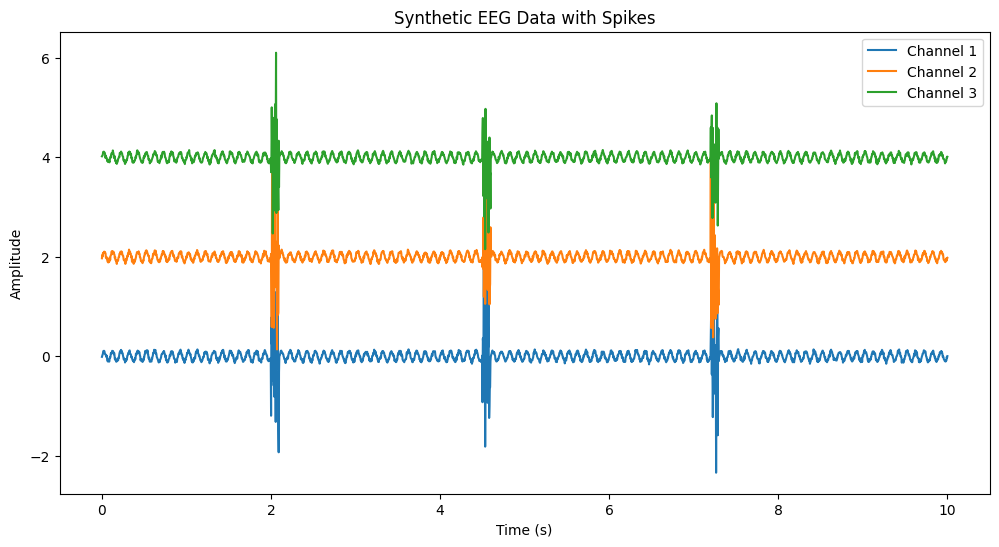

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the synthetic EEG
sampling_rate = 256  # Hz (typical EEG sampling rate)
duration = 10  # seconds
n_channels = 3  # Number of EEG channels
t = np.linspace(0, duration, int(sampling_rate * duration))  # Time vector

# Generate sinusoidal EEG signals (normal brain activity)
normal_eeg = 0.1 * np.sin(2 * np.pi * 10 * t)  # 10 Hz alpha wave

# Add some random noise to simulate natural variations
eeg_data = np.array([normal_eeg + 0.02 * np.random.randn(len(t)) for _ in range(n_channels)])

# Insert synthetic spikes into the EEG data
def add_spike(data, spike_amplitude, spike_duration, spike_times):
    spike_samples = int(spike_duration * sampling_rate)
    for time in spike_times:
        start_idx = int(time * sampling_rate)
        data[:, start_idx : start_idx + spike_samples] += spike_amplitude * np.random.randn(data.shape[0], spike_samples)
    return data

# Parameters for spikes
spike_amplitude = 1.0  # Amplitude of the spikes
spike_duration = 0.1  # Duration of each spike in seconds
spike_times = [2, 4.5, 7.2]  # Times (in seconds) where spikes occur

eeg_data_with_spikes = add_spike(eeg_data, spike_amplitude, spike_duration, spike_times)

# Plot the synthetic EEG data with spikes
plt.figure(figsize=(12, 6))
for i in range(n_channels):
    plt.plot(t, eeg_data_with_spikes[i] + i * 2, label=f'Channel {i+1}')  # Offset channels for visualization
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic EEG Data with Spikes')
plt.legend()
plt.show()


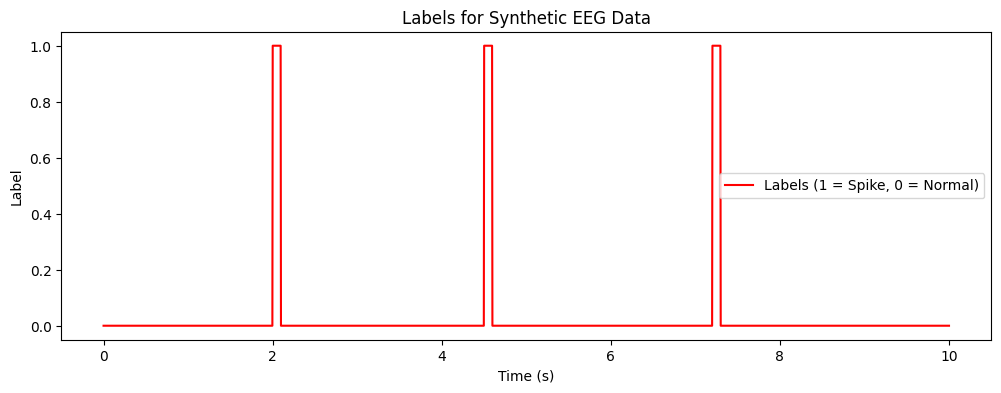

In [ ]:
# Generate annotations (0 = non-epileptic, 1 = epileptic)
labels = np.zeros_like(t)
for time in spike_times:
    start_idx = int(time * sampling_rate)
    end_idx = start_idx + int(spike_duration * sampling_rate)
    labels[start_idx:end_idx] = 1

# Plot labels
plt.figure(figsize=(12, 4))
plt.plot(t, labels, label='Labels (1 = Spike, 0 = Normal)', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Label')
plt.title('Labels for Synthetic EEG Data')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame to store EEG data and labels
eeg_df = pd.DataFrame(eeg_data_with_spikes.T, columns=[f'Channel_{i+1}' for i in range(n_channels)])
eeg_df['Time'] = t
eeg_df['Label'] = labels

# Save to a CSV file
eeg_df.to_csv('synthetic_eeg_with_spikes.csv', index=False)
print("Synthetic EEG dataset saved as 'synthetic_eeg_with_spikes.csv'")


Synthetic EEG dataset saved as 'synthetic_eeg_with_spikes.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('synthetic_eeg_with_spikes.csv')

# Separate features (EEG channels) and labels
X = data[['Channel_1', 'Channel_2', 'Channel_3']].values  # Adjust if more channels
y = data['Label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessed. Ready for training.")


Data preprocessed. Ready for training.


In [ ]:
print(df.columns)


Index(['Channel_1', 'Channel_2', 'Channel_3', 'Time', 'Label'], dtype='object')


In [ ]:
# Features: EEG channels
X = df[['Channel_1', 'Channel_2', 'Channel_3']].values  # EEG signal data
# Labels: Spike or no spike
y = df['Label'].values  # Target labels (0 or 1)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Features shape: (2560, 3)
Labels shape: (2560,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (2048, 3), Testing set shape: (512, 3)


In [ ]:
from brian2 import *

# Parameters
n_input = X_train.shape[1]  # Number of input neurons (3 channels)
n_hidden = 50               # Number of hidden neurons
n_output = 2                # Output neurons (spike/no spike)
tau = 10 * ms               # Membrane time constant
runtime = 100 * ms          # Simulation time per sample

# Neuron model equations
eqs = '''
dv/dt = -v / tau : 1
'''

# Neuron groups
input_layer = NeuronGroup(n_input, 'v:1', threshold='v>1', reset='v=0', method='linear')
hidden_layer = NeuronGroup(n_hidden, eqs, threshold='v>1', reset='v=0', method='euler')
output_layer = NeuronGroup(n_output, eqs, threshold='v>1', reset='v=0', method='euler')

# Synapses
input_to_hidden = Synapses(input_layer, hidden_layer, on_pre='v += 0.2')
input_to_hidden.connect(p=0.5)
hidden_to_output = Synapses(hidden_layer, output_layer, on_pre='v += 0.5')
hidden_to_output.connect(p=0.5)

# Monitors
input_monitor = SpikeMonitor(input_layer)
hidden_monitor = SpikeMonitor(hidden_layer)
output_monitor = SpikeMonitor(output_layer)

# Network
network = Network(input_layer, hidden_layer, output_layer, input_to_hidden, hidden_to_output,
                  input_monitor, hidden_monitor, output_monitor)


INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


Training Accuracy: 97.17%
Testing Accuracy: 96.68%


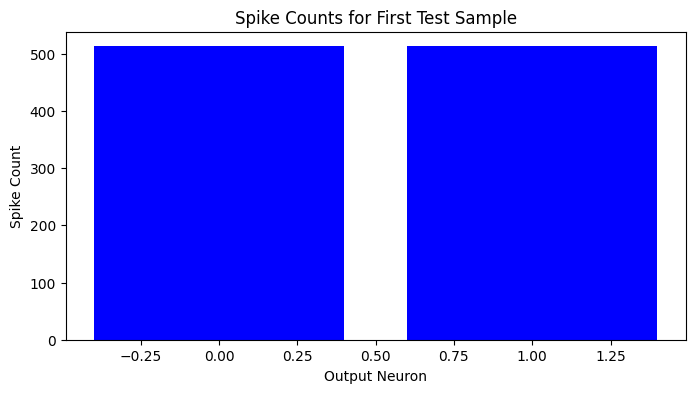

In [ ]:

import pandas as pd
import numpy as np
from brian2 import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('synthetic_eeg_with_spikes.csv')

# Extract features and labels
X = df[['Channel_1', 'Channel_2', 'Channel_3']].values  # EEG channels
y = df['Label'].values  # Spike labels (0: no spike, 1: spike)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SNN parameters
input_size = X.shape[1]
hidden_size = 10
output_size = 2

tau = 10 * ms
v_rest = -65 * mV
v_threshold = -50 * mV
v_reset = -65 * mV
refractory_period = 5 * ms
runtime = 1 * ms

# Neuron groups
input_layer = NeuronGroup(input_size, 'dv/dt = (v_rest - v) / tau : volt',
                          threshold='v > v_threshold', reset='v = v_reset', refractory=refractory_period)
hidden_layer = NeuronGroup(hidden_size, 'dv/dt = (v_rest - v) / tau : volt',
                           threshold='v > v_threshold', reset='v = v_reset', refractory=refractory_period)
output_layer = NeuronGroup(output_size, 'dv/dt = (v_rest - v) / tau : volt',
                           threshold='v > v_threshold', reset='v = v_reset', refractory=refractory_period)

# Synapses
input_to_hidden = Synapses(input_layer, hidden_layer, 'w : volt', on_pre='v_post += w')
hidden_to_output = Synapses(hidden_layer, output_layer, 'w : volt', on_pre='v_post += w')

# Connect synapses
input_to_hidden.connect()
hidden_to_output.connect()

# Initialize weights
input_to_hidden.w = 'randn() * 2 * mV'
hidden_to_output.w = 'randn() * 2 * mV'

# Spike monitor
output_monitor = SpikeMonitor(output_layer)

# Create a network
network = Network(input_layer, hidden_layer, output_layer, input_to_hidden, hidden_to_output, output_monitor)

# Function to run the SNN for a dataset
def run_snn(data, labels):
    predictions = []
    for sample in data:
        # Encode features as input voltages
        input_layer.v = sample * mV

        # Run the network
        network.run(runtime)

        # Count spikes
        spike_counts = np.zeros(output_size)
        for i in output_monitor.i:
            spike_counts[i] += 1

        # Predict the label based on the neuron with the highest spike count
        predicted_label = np.argmax(spike_counts)
        predictions.append(predicted_label)

        # Reset neuron voltages
        input_layer.v = 0 * mV
        hidden_layer.v = 0 * mV
        output_layer.v = 0 * mV

        # Clear spike monitor
        output_monitor.record = False
        output_monitor.record = True

    return predictions

# Train and test the SNN
train_predictions = run_snn(X_train, y_train)
test_predictions = run_snn(X_test, y_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Visualize spike counts for the first test sample
input_layer.v = X_test[0] * mV
network.run(runtime)
spike_counts = np.zeros(output_size)
for i in output_monitor.i:
    spike_counts[i] += 1

plt.figure(figsize=(8, 4))
plt.bar(range(output_size), spike_counts, color='blue')
plt.xlabel('Output Neuron')
plt.ylabel('Spike Count')
plt.title('Spike Counts for First Test Sample')
plt.show()
